In [29]:
# ### Get images with kaggle
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("adityajn105/flickr30k")

# print("flicker30k/Images/", path)
# THE WORKING ENV FOR THIS IS CPSC_3990 but it needs to be moved to a different pyhton version to work with cuda
!python --version

Python 3.12.9


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
import os
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

import torch
from datasets import Dataset, Image
from torch.utils.data import DataLoader

from typing import List, Union, Tuple

from transformers import CLIPProcessor, CLIPModel

import faiss # to use gpu version need python3.8

In [18]:
device = "cpu" #setting up cuda

# loading CLIP model and its processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# getting image paths
import os

# Define the base directory where your images are stored
# base_dir = '/home/jjtribb/CPSC_6070/repos/memory-retrieval/flicker30k/Data/' #full 30k Image dataset. We should fine tune clip on 100 images of us and see if it can pick us out of the thousands. 
base_dir = '/home/jjtribb/CPSC_6070/repos/memory-retrieval/testing_photos'
# Get all image file paths in the directory that end with .jpg
image_path = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.jpg')]
image_path.sort()
# print(image_path)

In [30]:
#this bassically querys some vlm to make descriptions of images and vectorize them
def encode_images(images: Union[List[str], List[PIL.Image.Image]], batch_size: int):
    def transform_fn(el):
        if isinstance(el['image'], PIL.Image.Image):
            imgs = el['image']
        else:
            imgs = [Image().decode_example(_) for _ in el['image']]
        return preprocess(images=imgs, return_tensors='pt')
        
    dataset = Dataset.from_dict({'image': images})
    dataset = dataset.cast_column('image',Image(decode=False)) if isinstance(images[0], str) else dataset       
    dataset.set_format('torch')
    dataset.set_transform(transform_fn)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    pbar = tqdm(total=len(images) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            image_embeddings.extend(model.get_image_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(image_embeddings)

vector_embedding = np.array(encode_images(image_path,32))

100%|██████████| 25/25 [00:54<00:00,  2.16s/it]


In [20]:
with open('flicker30k_image_embeddings.pkl','wb') as f:
    pickle.dump(vector_embedding, f)

In [31]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

In [32]:
#takes input text and vectorize it so the to compare for similarity in database
def encode_text( text: List[str], batch_size: int):
    device =  "cpu"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: preprocess(text=el['text'], return_tensors="pt",
                                                        max_length=77, padding="max_length", truncation=True),
                            batched=True,
                            remove_columns=['text'])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            text_embeddings.extend(model.get_text_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)


search_text = "basketball game"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 11.84it/s]


In [25]:
# similarity search top two images
distances, indices = index.search(text_search_embedding.reshape(1, -1), 2) #2 represent top n results required
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

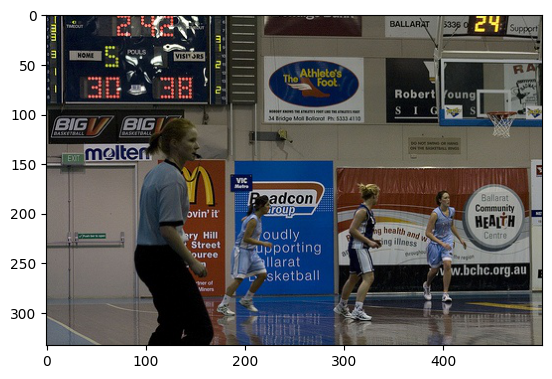

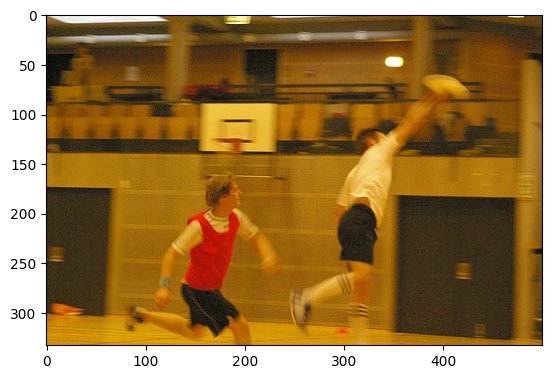

In [26]:
# this will output the results
from PIL import Image
for idx, distance in indices_distances:
    path = image_path[idx]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

